In [3]:
pip install matplotlib keract

  Using cached matplotlib-3.4.1-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached keract-4.4.0-py2.py3-none-any.whl (12 kB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
!nvidia-smi

Sat Apr 17 07:40:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   50C    P0    21W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input
# import tf_slim as slim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import keract
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import itertools
import random
%matplotlib inline
np.random.seed(2)

In [5]:
def SRM(imgs):
    filter1 = [[0, 0, 0, 0, 0],
               [0, -1, 2, -1, 0],
               [0, 2, -4, 2, 0],
               [0, -1, 2, -1, 0],
               [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
               [2, -6, 8, -6, 2],
               [-2, 8, -12, 8, -2],
               [2, -6, 8, -6, 2],
               [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, -2, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]
    q = [4.0, 12.0, 2.0]
    filter1 = np.asarray(filter1, dtype=float) / 4
    filter2 = np.asarray(filter2, dtype=float) / 12
    filter3 = np.asarray(filter3, dtype=float) / 2
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = tf.Variable(filters, dtype=tf.float32)
    imgs = np.array(imgs, dtype=float)
    input = tf.Variable(imgs, dtype=tf.float32)
    op = tf.nn.conv2d(input, filters, strides=[1, 1, 1, 1], padding='SAME')

    q = [4.0, 12.0, 2.0]
    filter1 = [[0, 0, 0, 0, 0],
            [0, -1, 2, -1, 0],
            [0, 2, -4, 2, 0],
            [0, -1, 2, -1, 0],
            [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
            [2, -6, 8, -6, 2],
            [-2, 8, -12, 8, -2],
            [2, -6, 8, -6, 2],
            [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 1, -2, 1, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]
    filter1 = np.asarray(filter1, dtype=float) / q[0]
    filter2 = np.asarray(filter2, dtype=float) / q[1]
    filter3 = np.asarray(filter3, dtype=float) / q[2]
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = filters.flatten()
    imgs = np.array(imgs, dtype=float)
    input = tf.Variable(imgs, dtype=tf.float32)
    initializer_srm = tf.constant_initializer(filters)
    def truncate_2(x):
        neg = ((x + 2) + abs(x + 2)) / 2 - 2
        return -(-neg+2 + abs(- neg+2)) / 2 + 2
    op2 = slim.conv2d(input, 3, [5, 5], trainable=False, weights_initializer=initializer_srm, activation_fn=None, padding='SAME', stride=1, scope='srm')
    op2 = truncate_2(op2)

    res = np.round(op[0])
    res[res > 2] = 2
    res[res < -2] = -2

    ress = np.array([res], dtype=float)
    ress2 = np.array(op2, dtype=float)
    return ress2

In [6]:
def initializer():
    # q = [4.0, 12.0, 2.0]
    # filter1 = [[0, 0, 0, 0, 0],
    #         [0, -1, 2, -1, 0],
    #         [0, 2, -4, 2, 0],
    #         [0, -1, 2, -1, 0],
    #         [0, 0, 0, 0, 0]]
    # filter2 = [[-1, 2, -2, 2, -1],
    #         [2, -6, 8, -6, 2],
    #         [-2, 8, -12, 8, -2],
    #         [2, -6, 8, -6, 2],
    #         [-1, 2, -2, 2, -1]]
    # filter3 = [[0, 0, 0, 0, 0],
    #         [0, 0, 0, 0, 0],
    #         [0, 1, -2, 1, 0],
    #         [0, 0, 0, 0, 0],
    #         [0, 0, 0, 0, 0]]
    # filter1 = np.asarray(filter1, dtype=float) / q[0]
    # filter2 = np.asarray(filter2, dtype=float) / q[1]
    # filter3 = np.asarray(filter3, dtype=float) / q[2]
    # filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    # filters = np.einsum('klij->ijlk', filters)
    # filters = filters.flatten()
    # initializer_srm = tf.constant_initializer(filters)

    filter1 = [[0, 0, 0, 0, 0],
               [0, -1, 2, -1, 0],
               [0, 2, -4, 2, 0],
               [0, -1, 2, -1, 0],
               [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
               [2, -6, 8, -6, 2],
               [-2, 8, -12, 8, -2],
               [2, -6, 8, -6, 2],
               [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, -2, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]
    filter1 = np.asarray(filter1, dtype=float) / 4
    filter2 = np.asarray(filter2, dtype=float) / 12
    filter3 = np.asarray(filter3, dtype=float) / 2
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = tf.Variable(filters, dtype=tf.float32)
    return filters

In [8]:
h = 224
w = 224
image_size = (h, w)

# np_arr = lambda img: img.resize(image_size).flatten() / 255.0
np_arr = lambda img: np.array(img.resize(image_size)).flatten() / 255.0

def prepare_image(image_path):
    # img = Image.open(image_path)
    # img = img.resize(image_size)
    # img = np.asarray(img)
    # imgs = np.array(img, dtype=float)
    # input = tf.Variable(imgs, dtype=tf.float32)
    return np_arr(Image.open(image_path))
    # SRM([img])

In [9]:
# img = prepare_image('./example_images/Tp_D_CNN_S_O_nat10153_ani00097_12135.jpg')
# img.shape

In [10]:
# img = Image.open('Tp_D_NNN_M_N_pla10121_cha00027_11669.jpg')
# # img = np.asarray(img)
# img = img.resize(image_size)
# img = np.asarray(img) /255.0
# img.shape

In [11]:
# cat = prepare_image('./example_images/Tp_D_CNN_S_O_nat10153_ani00097_12135.jpg')
# plt.imshow(cat[0])
# # plt.show()
# plt.axis('off')
# plt.savefig("srm.png", bbox_inches='tight', pad_inches=0)

In [12]:
X = [] # SRM converted images
Y = [] # 0 for fake, 1 for real

In [13]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X.append(prepare_image(full_path))
                    Y.append(cls)
                except:
                    pass
                if len(Y) % 500 == 0:
                    print('Processing {} images'.format(len(Y)))

In [ ]:
#place authentic
Au_path = 'forgery/data/Au'
prepare_data(Au_path, 1)
random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images


/usr/local/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images


In [16]:
#place tampered
Tp_path = 'forgery/data/Tp'
prepare_data(Tp_path, 0)
print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [17]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, h, w, 3)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

X = X.reshape(-1,1,1,1)

In [18]:
def truncate_2(x):
    neg = ((x + 2) + abs(x + 2)) / 2 - 2
    return -(-neg+2 + abs(- neg+2)) / 2 + 2

In [19]:
initializer_srm = initializer()

In [44]:
input = Input(shape=(h,w,3))
op = tf.nn.conv2d(input, initializer_srm, strides=[1, 1, 1, 1], padding='SAME', name='srm-layer')
x = Conv2D(64, 3, activation='relu', padding='same')(op)
x = BatchNormalization()(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)
x = Conv2D(512, 3, activation='relu', padding='same')(x)

x = Flatten()(x)
# x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

output = Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_srm-layer_6 (Ten [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_69 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_70 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 112, 112, 64)    

In [45]:
epochs = 30
batch_size = 32
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=2, verbose=0, mode='auto')

checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/30
  2/105 [..............................] - ETA: 19s - loss: 1.0746 - accuracy: 0.6562WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1158s vs `on_train_batch_end` time: 0.2645s). Check your callbacks.


105/105 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.5965WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 51s 484ms/step - loss: 0.7348 - accuracy: 0.5965 - val_loss: 0.7011 - val_accuracy: 0.4886
Epoch 2/30
105/105 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7229WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 51s 484ms/step - loss: 0.5682 - accuracy: 0.7229 - val_loss: 0.7664 - val_accuracy: 0.5114
Epoch 3/30
105/105 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8187WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 51s 482ms/step - loss: 0.4338 - accuracy: 0.8187 - val_loss: 0.6889 - val_accuracy: 0.5318
Epoch 4/30
105/105 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8547WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 51s 482ms/step - loss: 0.3987 - accuracy: 0.8547 - val_loss: 0.6788 - val_accuracy: 0.5786
Epoch 5/30
105/105 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8901WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 44s 417ms/step - loss: 0.3257 - accuracy: 0.8901 - val_loss: 0.7782 - val_accuracy: 0.5402
Epoch 6/30
105/105 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8997WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 45s 426ms/step - loss: 0.3138 - accuracy: 0.8997 - val_loss: 1.5357 - val_accuracy: 0.5246
Epoch 7/30
105/105 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9114WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 52s 496ms/step - loss: 0.2798 - accuracy: 0.9114 - val_loss: 0.8100 - val_accuracy: 0.6351
Epoch 8/30
105/105 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9307WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 51s 481ms/step - loss: 0.2240 - accuracy: 0.9307 - val_loss: 0.7548 - val_accuracy: 0.6735
Epoch 9/30
105/105 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9469WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 50s 480ms/step - loss: 0.2019 - accuracy: 0.9469 - val_loss: 0.7863 - val_accuracy: 0.7323
Epoch 10/30
105/105 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.9243WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 43s 412ms/step - loss: 0.2518 - accuracy: 0.9243 - val_loss: 1.2361 - val_accuracy: 0.5474
Epoch 11/30
105/105 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9358WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 51s 488ms/step - loss: 0.2285 - accuracy: 0.9358 - val_loss: 0.7336 - val_accuracy: 0.7359
Epoch 12/30
105/105 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9583WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 52s 496ms/step - loss: 0.1655 - accuracy: 0.9583 - val_loss: 0.7407 - val_accuracy: 0.7479
Epoch 13/30
105/105 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9637WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 44s 422ms/step - loss: 0.1570 - accuracy: 0.9637 - val_loss: 1.0733 - val_accuracy: 0.5462
Epoch 14/30
105/105 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9706WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 43s 412ms/step - loss: 0.1423 - accuracy: 0.9706 - val_loss: 0.8023 - val_accuracy: 0.7311
Epoch 15/30
105/105 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9673WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 43s 408ms/step - loss: 0.1569 - accuracy: 0.9673 - val_loss: 1.0380 - val_accuracy: 0.5930
Epoch 16/30
105/105 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9751WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 43s 411ms/step - loss: 0.1174 - accuracy: 0.9751 - val_loss: 1.0987 - val_accuracy: 0.5690
Epoch 17/30
105/105 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9757WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 44s 416ms/step - loss: 0.1267 - accuracy: 0.9757 - val_loss: 0.7338 - val_accuracy: 0.7275
Epoch 18/30
105/105 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9787WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


105/105 [==============================] - 44s 421ms/step - loss: 0.1117 - accuracy: 0.9787 - val_loss: 1.1160 - val_accuracy: 0.6158
Epoch 19/30
 34/105 [========>.....................] - ETA: 27s - loss: 0.0731 - accuracy: 0.9881

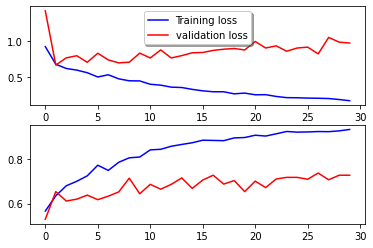

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

In [30]:
cat = np.array(Image.open('cat.jpg').resize(image_size)).flatten() / 255.0
cat = cat.reshape(-1, 224, 224, 3)

In [31]:
a = keract.get_activations(model, cat)

In [32]:
keract.display_activations(a, directory='cat_activations', save=True, fig_size=(100,24))

input_1 (1, 224, 224, 3) 
tf_op_layer_srm-layer (1, 224, 224, 3) 
conv2d (1, 224, 224, 64) 
batch_normalization (1, 224, 224, 64) 
conv2d_1 (1, 224, 224, 64) 
batch_normalization_1 (1, 224, 224, 64) 
max_pooling2d (1, 112, 112, 64) 
batch_normalization_2 (1, 112, 112, 64) 
conv2d_2 (1, 112, 112, 128) 
batch_normalization_3 (1, 112, 112, 128) 
conv2d_3 (1, 112, 112, 128) 
batch_normalization_4 (1, 112, 112, 128) 
max_pooling2d_1 (1, 56, 56, 128) 
batch_normalization_5 (1, 56, 56, 128) 
conv2d_4 (1, 56, 56, 256) 
batch_normalization_6 (1, 56, 56, 256) 
conv2d_5 (1, 56, 56, 256) 
batch_normalization_7 (1, 56, 56, 256) 
conv2d_6 (1, 56, 56, 256) 
batch_normalization_8 (1, 56, 56, 256) 
max_pooling2d_2 (1, 28, 28, 256) 
batch_normalization_9 (1, 28, 28, 256) 
conv2d_7 (1, 28, 28, 512) 
batch_normalization_10 (1, 28, 28, 512) 
conv2d_8 (1, 28, 28, 512) 
batch_normalization_11 (1, 28, 28, 512) 
conv2d_9 (1, 28, 28, 512) 
max_pooling2d_3 (1, 14, 14, 512) 
batch_normalization_12 (1, 14, 14, 512

In [15]:
model.load_weights(checkpoint_filepath)

In [3]:
# def SRM(imgs):
#     c=np.zeros((3,5,5))
#     c[0]=[[-1,2,-2,2,-1],[2,-6,8,-6,2],[-2,8,-12,8,-2],[2,-6,8,-6,2],[-1,2,-2,2,-1]]
#     c[0]=c[0]/12

#     c[1][1][1]=-1
#     c[1][1][2]=2
#     c[1][1][3]=-1
#     c[1][2][1]=2
#     c[1][2][2]=-4
#     c[1][2][3]=2
#     c[1][3][1]=-1
#     c[1][3][2]=2
#     c[1][3][3]=-1
#     c[1]=c[1]/4

#     c[2][1][2]=1
#     c[2][2][2]=-2
#     c[2][3][2]=1
#     c[2]=c[2]/2   

#     Wcnn=np.zeros((5,5,3,3))
#     for i in range(3):
#         Wcnn[:,:,0,i]=c[i]
#         Wcnn[:,:,1,i]=c[i]
#         Wcnn[:,:,2,i]=c[i]

#     imgs = np.array(imgs, dtype=float)
#     input = tf.Variable(imgs, dtype=tf.float32)

#     conv = tf.nn.conv2d(input, Wcnn, [1, 1, 1, 1], padding='SAME',name='srm')
#     res = np.array(conv, dtype=float)
#     return res